In [1]:
#Needed in general


# import numpy as np
# import matplotlib.pyplot as plt
import sys
# import h5py as h5
# import gc

#Quick fudge to make import from ../Scripts work
sys.path.append('../Scripts')

#Custom imports
# import ClassCOMPAS     as CC ###
# import ClassFormationChannels as FC a


# import script that has formation channel classification functions:
from PostProcessingScripts import * 
# from ClassFormationChannels_5mainchannels import * 



from astropy import units as u
from astropy import constants as const

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# print(fs)

# import astropy
# import seaborn as sns
# from seaborn_utility import cmap_from_colour

# from astropy import units as u
# from astropy import constants as c

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

from KDEpy import FFTKDE
from scipy.stats import norm

colors = ['#1f77b4', '#ff7f0e']
colors_lighter = [adjust_lightness(color=colors[0], amount=2.2),adjust_lightness(color=colors[1], amount=1.7)]



# Generate a distribution and draw 2**6 data points


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

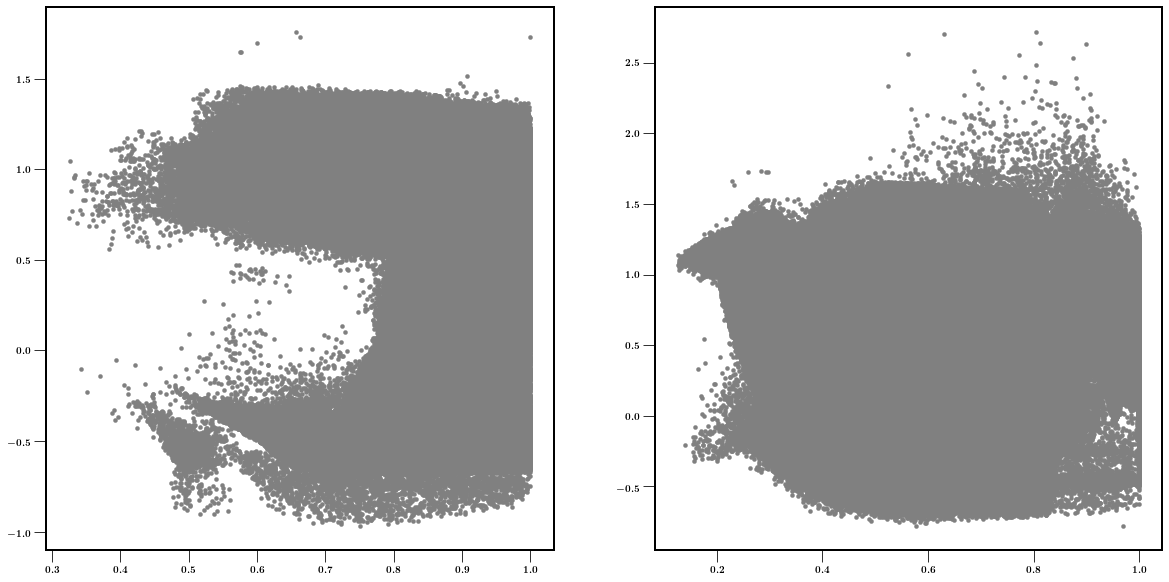

In [11]:






def plot_MRR_distribution(axe='None', xparam='chiEff', BPSmodelName='A', mode='pdf',\
                          spin_threshold='None', bw=0.01, xlim=[0,1], ylim=[0,1],\
                          plotYlog='False', ylim_threshold=0.02):#, mssfr='112'):
    
    fs_l = 28 # label fontsize
    
    colors = ['#1f77b4', '#ff7f0e']
    colors_lighter = [adjust_lightness(color=colors[0], amount=2.2),adjust_lightness(color=colors[1], amount=1.7)]

    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    
    fdata = h5.File(path, 'r')
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    seedsDCO  = fdata['doubleCompactObjects']['seed'][...].squeeze()  # get the seeds in the DCO file 
    seedsSN   = fdata['supernovae']['randomSeed'][...].squeeze()    # get the seeds in the SN file 
    indices   = np.sort(np.unique(seedsSN[1::2], return_index=True)[1])
    maskSNdco = np.in1d(seedsSN,  seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
    whichSN   = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]  # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova     
    whichSN2  = whichSN[1::2][indices]

    # either SN2 = primary (1) and M1 is > M2, or SN2 = secondary & M1 < M2 
    # this takes into account (first term) rejuvenation 
    mask_MRR = ((whichSN2==1) & (massCO_ZAMSM1>massCO_ZAMSM2) ) | ((whichSN2==2) & (massCO_ZAMSM1<massCO_ZAMSM2)) 


    del whichSN2
    del whichSN
    del maskSNdco
    del indices
    del seedsSN
    del seedsDCO


    
    if (mode in ['spin_PDF', 'spin_fraction', 'spinOne_fraction', 'spinTwo_fraction', 'm1spin_or_m2spin_fraction', 'spin_CDF' ]) | (xparam in ['chi_of_spinning_BH', 'chi_effective', 'log10_t_delay']):
        spin = COspin(data_path=path, state='he_depletion')  # set class 
        spin.setCOMPASData() # reads in the COMPAS DCO parameters 
        spinZAMSM1, spinZAMSM2  = spin.BaveraSpin() #ZAMS M1 SPIN 

        spinLVKM1, spinLVKM2 = np.zeros_like(spinZAMSM1), np.zeros_like(spinZAMSM1)
        spinLVKM1[mask_MRR] = spinZAMSM2[mask_MRR]  # MRR so M1 comes from M2ZAMS, we assign it spin from M2ZAMS
        spinLVKM1[~mask_MRR] = spinZAMSM1[~mask_MRR]  # no MRR so M1 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinLVKM2[mask_MRR] = spinZAMSM1[mask_MRR]   # MRR so M2 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinLVKM2[~mask_MRR] = spinZAMSM2[~mask_MRR]   # no MRR so M2 comes from M2ZAMS, we assign it spin from M2ZAMS     

        # spin_threshold = 0.05 # definition of "spinning BH"
        mask_LVKM1_spinning = (spinLVKM1 > spin_threshold ) 
        mask_LVKM2_spinning = (spinLVKM2 > spin_threshold ) # definition of "spinning BH"
        mask_anySpin = (spinLVKM1 > spin_threshold ) | (spinLVKM2 > spin_threshold )    

    

    if xparam=='chirp_mass_LVK':
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
        nameX = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,100,1000)

    elif xparam=='mass_ratio_LVK':
        param_x = MassRatioCO_LVK
        nameX = r'$q$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,1.2,1000)
        
    elif xparam=='chi_of_spinning_BH':
        param_x = spinLVKM1 + spinLVKM2

        nameX = r'$\chi_{\rm{i}}$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,2,1000)  

        
    elif xparam=='chi_effective':
        param_x = ((spinLVKM1*massCO_LVKM1) + (spinLVKM2*massCO_LVKM2)) / (massCO_LVKM1+massCO_LVKM2)
        nameX = r'$\chi_{\rm{eff}}$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,2,1000)          
        
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        nameX = r'$t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-4,2,1000) 
        
    elif xparam=='qseparation':
        param_x = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()/fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze() # mass ratio 
        param_ynotlog = fdata['doubleCompactObjects']['separationInitial'][...].squeeze() # in AU 
        param_y = np.log10(param_ynotlog)
        nameY = 'separationInitial [AU]'
        nameX = 'mass ratio'
        
    

    
 






            
            
        
        
        axe[0].scatter(param_x[mask_MRR], param_y[mask_MRR], s=20, color='gray', linewidth=0.1)
        
        axe[1].scatter(param_x[~mask_MRR],param_y[~mask_MRR],s=20, color='gray', linewidth=0.1)        

                
    
        



    
    return axe 



f, ax= plt.subplots(ncols=2,nrows=1, figsize=(20,10))



BPS = 'B'

plot_MRR_distribution(axe=ax, xparam='qseparation', BPSmodelName=BPS)




In [ ]:





# prepare legend label:


legendlabel = []
for ind, key in enumerate(dictChannelsBHNSList):
    
    print(str((round(dictPercentages[key],2))) + str(r'\%'))
    string = dictChannelsBHNSListBolt[ind] #+# ' '# + r'$%s$'%str((roundAndFormat1(dictPercentages[key]))) + str(r'\%')
    print(string)
    legendlabel.append(string)
    
    


In [ ]:


LOOP = False

# Use MSSFR Integrated weights?
WeightsRateIntrinsic_zIntegrated=False
if WeightsRateIntrinsic_zIntegrated==False:
    ModelName = 'notMSSFRweighted'

# multiply weights with this no to obtain scatter point area size
stimes_weight = 25

metallicities = [0.0014,  0.01269]


print('-----------------')
print('now doing initial masses (top panels)')
print('-----------------')

f, ax= plt.subplots(ncols=2,nrows=2, figsize=(16,16), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})




#### PLOT SEPARATION AND MASS RATIO ###
xlabel = r'\textbf{initial mass} $m_{1,{\rm{i}}} \, [\rm{M}_{\odot}]$'
ylabel = r'\textbf{initial mass} $m_{2,{\rm{i}}} \, [\rm{M}_{\odot}]$'


PlotText = True
fc=None

handles, labels = plotInitialMasses(ax=ax[0], fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList,channelLabelList=range(8), withinHubble=True)

lgd2 = f.legend(handles, legendlabel, fontsize=20, ncol=3,\
         bbox_to_anchor=(1.0, 1.1),  markerscale=3., scatterpoints=1) # loc = 'upper center')






markersize_lgd = 200
lgd2.legendHandles[0]._sizes = [markersize_lgd]
lgd2.legendHandles[1]._sizes = [markersize_lgd]
lgd2.legendHandles[2]._sizes = [markersize_lgd]
lgd2.legendHandles[3]._sizes = [markersize_lgd]
lgd2.legendHandles[4]._sizes = [markersize_lgd]



xlabel = r'\textbf{initial mass ratio} $q_{\rm{i}} $'
ylabel = r'\textbf{initial semi-major axis} $\log_{10}(a_{\rm{i}}) \, [\rm{AU}]$'

print('-----------------')
print('now doing q vs separation (bottom panels)')
print('-----------------')


# whether to plot labels text
PlotText = False
handles, labels = plotInitialqVSseparation(ax=ax[1], fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList, withinHubble=True)




##### ADD ARROWS ####

print('-----------------')
print('now drawing arrows')
print('-----------------')


# properties  arrow 
strr = r"\textbf{case A} "
x_xy, y_xy = 0.8, 0.2
x_xytext, y_xytext = 0.8, 0.4
conn = "arc3,rad=+0.0"

# draw arrow
ax[1,0].annotate(strr,
  xy=(x_xy, y_xy), xycoords='axes fraction',
  xytext=(x_xytext, y_xytext), textcoords='axes fraction',
  size=20, va="center", ha="right",
  arrowprops=dict(arrowstyle="-|>",
                  connectionstyle=conn,
                  fc="k", lw=3.5), zorder=20000)



# properties  arrow 
strr = r"\textbf{case C} "
x_xy, y_xy = 0.3, 0.7
x_xytext, y_xytext = 0.25, 0.9
conn = "arc3,rad=+0.3"

# draw arrow
ax[1,0].annotate(strr,
  xy=(x_xy, y_xy), xycoords='axes fraction',
  xytext=(x_xytext, y_xytext), textcoords='axes fraction',
  size=20, va="center", ha="right",
  arrowprops=dict(arrowstyle="-|>",
                  connectionstyle=conn,
                  fc="k", lw=3.5), zorder=20000)

# properties arrow 
strr = r"\textbf{case B} "
x_xy, y_xy = 0.6, 0.3
x_xytext, y_xytext = 0.7, 0.1
conn = "arc3,rad=+0.1"

# draw arrow redshift
ax[1,1].annotate(strr,
  xy=(x_xy, y_xy), xycoords='axes fraction',
  xytext=(x_xytext, y_xytext), textcoords='axes fraction',
  size=20, va="center", ha="left",
  arrowprops=dict(arrowstyle="-|>",
                  connectionstyle=conn,
                  fc="k", lw=3.5), zorder=20000)


# properties arrow 
strr = r"\textbf{`lucky SN'} "
x_xy, y_xy = 0.4, 0.9
x_xytext, y_xytext = 0.3, 0.95
conn = "arc3,rad=+0.0"
# draw arrow 
ax[1,1].annotate(strr,
  xy=(x_xy, y_xy), xycoords='axes fraction',
  xytext=(x_xytext, y_xytext), textcoords='axes fraction',
  size=20, va="center", ha="right",
  arrowprops=dict(arrowstyle="-|>",
                  connectionstyle=conn,
                  fc="k", lw=3.5), zorder=20000)

#########
#####  ####

print('-----------------')
print('now saving figure')
print('-----------------')

# save and show 
f.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5) 
f.savefig('./BHNS_InitialParameters_'+ ModelName + 'lowres.png', bbox_extra_artists=(lgd2,), bbox_inches='tight', dpi = 50)
# f.savefig('./BHNS_InitialParameters_'+ ModelName + '.pdf', bbox_extra_artists=(lgd2,), bbox_inches='tight')
plt.show()
plt.close()        

